# Hessian Weight Averaged Gaussian Calculation of Prediction Uncertainty

See [1](https://proceedings.neurips.cc/paper_files/paper/2019/hash/118921efba23fc329e6560b27861f0c2-Abstract.html), [2](https://link.springer.com/chapter/10.1007/978-3-031-16749-2_8). 

Instead of using SGD to obtain an ensemble of models from which to calculate a distribution $\mathcal{N}(\mu_{\theta}, \sigma_{\theta})$, where $\theta$ represents the set of all parameters in the ensemble, this code uses the loss landscape to identify which models have similar performance.

In [1]:
import os
import copy
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets

from alignn.pretrained import *

from src.utils import *
from src import botcher_hessian_alignn as hess
from src import botcher_utilities as util
from src.hessian_wag_alignn import get_hessian_wag
from src.hessian_wag_alignn import get_sample_from_normal_dist_of_models

In [2]:
device = 'cuda'

# Load Model

In [3]:
style = {'description_width': 'initial'}

config_selector = widgets.Dropdown(
    options=list(get_all_models().keys()),
    value=list(get_all_models().keys())[0],
    description='Select Model',
    style=style,
    disabled=False,
)

display(config_selector)

Dropdown(description='Select Model', options=('jv_formation_energy_peratom_alignn', 'jv_optb88vdw_total_energy…

In [4]:
# This is the model we will load
model_name = config_selector.value
print("Selected: ", model_name)

Selected:  jv_formation_energy_peratom_alignn


In [5]:
model, model_wt_dict = load_pretrained_model(model_name)

Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /home/ashley/miniconda3/envs/loss_landscapes_demo/lib/python3.10/site-packages/alignn/jv_formation_energy_peratom_alignn.zip
Config /home/ashley/loss_landscapes_demo/jv_formation_energy_peratom_alignn/config.json


/home/ashley/miniconda3/envs/loss_landscapes_demo/lib/python3.10/site-packages/alignn/pretrained.py:292: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(

# Load Data

In [6]:
# target = 'optb88vdw_bandgap'
target = 'formation_energy_peratom'
n_samples = 1000 # for all samples, pass -1
element_to_omit_from_training_data = 'Fe'
n_z_samples_for_hessian = 100

In [7]:
train_data_list, test_data_list = load_data(
    element_to_omit_from_training_data, n_samples
)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
num train samples: 927
num test samples: 73


In [8]:
train_dataloader = get_data_loader(train_data_list, target)

data range 5.28308 -4.0858
Converting to graphs!


100%|██████████| 927/927 [00:07<00:00, 131.20it/s]


df                                                  atoms     prop  jid
0    {'lattice_mat': [[3.566933224304235, 0.0, -0.0... -0.42762    0
1    {'lattice_mat': [[4.089078911208881, 0.0, 0.0]... -0.41596    1
2    {'lattice_mat': [[-1.833590720595598, 1.833590...  0.04847    2
3    {'lattice_mat': [[7.2963518353359165, 0.0, 0.0... -0.44140    3
4    {'lattice_mat': [[1.6777483798834445, -2.90594... -0.71026    4
..                                                 ...      ...  ...
922  {'lattice_mat': [[0.0, 5.004301514431302, 5.00...  1.16087  922
923  {'lattice_mat': [[4.496207811888019, 0.0, 0.0]... -1.90267  923
924  {'lattice_mat': [[0.0, 3.852051785372815, 3.85...  0.41960  924
925  {'lattice_mat': [[0.0, 4.9082744345175895, 4.9...  0.49906  925
926  {'lattice_mat': [[0.0, 4.920264584239658, 4.92...  0.92931  926

[927 rows x 3 columns]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available

100%|██████████| 927/927 [00:00<00:00, 3937.43it/s]


# Predicting on Test and Train Data

In [9]:
model_train_predictions = []
original_train_targets = []
for s in tqdm(train_dataloader):
    original_train_targets.append(s[2].detach().numpy()[0])
    y_pred = np.expand_dims(model([s[0].to(device), s[1].to(device)]).cpu().detach().numpy(), axis=0)[0]
    model_train_predictions.append(y_pred)

100%|██████████| 927/927 [00:11<00:00, 80.72it/s]


In [10]:
test_dataloader = get_data_loader(test_data_list, target)

model_test_predictions = []
original_test_targets = []
for s in tqdm(test_dataloader):
    original_test_targets.append(s[2].detach().numpy()[0])
    y_pred = np.expand_dims(model([s[0].to(device), s[1].to(device)]).cpu().detach().numpy(), axis=0)[0]
    model_test_predictions.append(y_pred)


data range 1.56755 -2.65468
Converting to graphs!


100%|██████████| 73/73 [00:00<00:00, 101.86it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[4.927781968323723, -0.0, 0.0... -1.78124   1
2   {'lattice_mat': [[4.839493559425439, 9.7116505... -1.66274   2
3   {'lattice_mat': [[5.464512229851642, 0.0, -2.0... -0.93989   3
4   {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   4
..                                                ...      ...  ..
68  {'lattice_mat': [[4.8166458682114435, -0.0, 0.... -1.28488  68
69  {'lattice_mat': [[0.0, 4.589959301088131, 0.00... -1.70084  69
70  {'lattice_mat': [[3.4709209595661688, -1.12804... -0.19524  70
71  {'lattice_mat': [[-0.0, 3.24316049942265, 3.24...  0.14577  71
72  {'lattice_mat': [[6.84938891863269, 1.15896e-1... -0.44277  72

[73 rows x 3 columns]
building line graphs


100%|██████████| 73/73 [00:00<00:00, 86.45it/s]


## Subselect Train Data Samples: Most ID (Minimum Error)

In [11]:
train_df = pd.DataFrame(train_data_list)
train_df['pred_val'] = model_train_predictions
train_df['err'] = (train_df[target] - train_df['pred_val'])
train_df['abs_err'] = np.abs(train_df[target] - train_df['pred_val'])
train_df['z_score_err'] = (train_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [12]:
train_subset_dataloader = load_zscore_sample(train_df, train_data_list, n_z_samples_for_hessian, target, 'low')

data range 2.71694 -3.24073
Converting to graphs!


100%|██████████| 100/100 [00:00<00:00, 139.64it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[5.614561710069512, -0.008098... -3.04140   0
1   {'lattice_mat': [[4.428712142345245, 0.0938283... -1.15984   1
2   {'lattice_mat': [[6.077481786895317, 0.0, 0.0]... -0.84152   2
3   {'lattice_mat': [[7.542839764249747, 0.1718970... -0.44498   3
4   {'lattice_mat': [[5.382597739169287, 0.0, -0.0... -2.65345   4
..                                                ...      ...  ..
95  {'lattice_mat': [[0.0, 0.0, -4.045454469777455... -0.56556  95
96  {'lattice_mat': [[3.1003051292413493, 1.053941... -0.24380  96
97  {'lattice_mat': [[4.284492173131309, 1.636192e... -0.42539  97
98  {'lattice_mat': [[-0.0, 5.083711045479688, 5.0...  0.25324  98
99  {'lattice_mat': [[4.01758725637e-05, 3.3723779... -0.08195  99

[100 rows x 3 columns]
building line graphs


100%|██████████| 100/100 [00:00<00:00, 3622.52it/s]


In [13]:
subset_train_x = []
subset_train_y = []

for i in train_subset_dataloader:
    subset_train_x.append((i[0], i[1]))
    subset_train_y.append(i[2])

## Subselect Test Samples - Most OOD (Maximum Error)

In [14]:
test_df = pd.DataFrame(test_data_list)
test_df['pred_val'] = model_test_predictions
test_df['err'] = (test_df[target] - test_df['pred_val'])
test_df['abs_err'] = np.abs(test_df[target] - test_df['pred_val'])
test_df['z_score_err'] = (test_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [15]:
test_subset_dataloader = load_zscore_sample(test_df, test_data_list, n_z_samples_for_hessian, target, 'high')

data range 1.56755 -2.65468
Converting to graphs!


100%|██████████| 73/73 [00:00<00:00, 102.99it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[0.0, 4.897056811995578, 4.89...  1.53929   1
2   {'lattice_mat': [[4.110215016104089, 0.0, 0.0]... -0.04638   2
3   {'lattice_mat': [[2.848077488322179, 2.8480774... -0.10758   3
4   {'lattice_mat': [[4.1657904284125715, 4.165790... -0.04919   4
..                                                ...      ...  ..
68  {'lattice_mat': [[3.0322342724503466, 3.032234... -0.07574  68
69  {'lattice_mat': [[5.4806740361592965, 0.006216... -2.32580  69
70  {'lattice_mat': [[6.089005018229488, -0.053950... -1.81340  70
71  {'lattice_mat': [[7.9088239538e-06, 3.00530731... -0.23500  71
72  {'lattice_mat': [[-0.0, 4.675841220418326, 3.0... -1.44871  72

[73 rows x 3 columns]
building line graphs


100%|██████████| 73/73 [00:00<00:00, 3725.41it/s]


# Load Pre-calculated Hessian Eigenvectors

In [16]:
func = copy.deepcopy(model)
model_eig_max = copy.deepcopy(func)
model_eig_max.load_state_dict(torch.load('model_eig_max.pt', weights_only=True))
model_eig_min = copy.deepcopy(func)
model_eig_min.load_state_dict(torch.load('model_eig_min.pt', weights_only=True))

<All keys matched successfully>

# Create Mean and Standard Deviation Models

The `loss_threshold` parameter controls which models from the loss landscape will be included in 
the average and standard deviation calculations.  Any model with average loss $\mathcal{L} > $`loss_threshold` will not
be included in the average or the standard deviation.

In [ ]:
STEPS = 20
loss_func = torch.nn.MSELoss()
loss_threshold = 1 #<--- this is an absolute upper bound.

In [18]:
loss_landscape, mu_model, stddev_model, model_loci = get_hessian_wag(
    train_subset_dataloader, loss_func, func.to('cpu'), STEPS, 
    model_eig_max.to('cpu'), model_eig_min.to('cpu'), loss_threshold=loss_threshold
    )

Getting Stddev Model: 100%|██████████| 20/20 [03:55<00:00, 11.78s/it]


In [33]:
model_loci

[(0, 0, tensor(2.0501)),
 (0, 1, tensor(2.1112)),
 (0, 2, tensor(2.1522)),
 (0, 3, tensor(2.1733)),
 (0, 4, tensor(2.1735)),
 (0, 5, tensor(2.1497)),
 (0, 6, tensor(2.0950)),
 (0, 7, tensor(1.9994)),
 (0, 8, tensor(1.8527)),
 (0, 9, tensor(1.6459)),
 (0, 10, tensor(1.3719)),
 (0, 11, tensor(1.0309)),
 (0, 12, tensor(0.6440)),
 (0, 13, tensor(0.2936)),
 (0, 14, tensor(0.1010)),
 (0, 15, tensor(0.1930)),
 (0, 16, tensor(0.6686)),
 (0, 17, tensor(1.5349)),
 (0, 18, tensor(2.7061)),
 (0, 19, tensor(4.0339)),
 (1, 0, tensor(3.2650)),
 (1, 1, tensor(2.1629)),
 (1, 2, tensor(1.1944)),
 (1, 3, tensor(0.4907)),
 (1, 4, tensor(0.1288)),
 (1, 5, tensor(0.1026)),
 (1, 6, tensor(0.3220)),
 (1, 7, tensor(0.6748)),
 (1, 8, tensor(1.0518)),
 (1, 9, tensor(1.3798)),
 (1, 10, tensor(1.6418)),
 (1, 11, tensor(1.8391)),
 (1, 12, tensor(1.9790)),
 (1, 13, tensor(2.0706)),
 (1, 14, tensor(2.1236)),
 (1, 15, tensor(2.1476)),
 (1, 16, tensor(2.1494)),
 (1, 17, tensor(2.1319)),
 (1, 18, tensor(2.0962)),
 (1, 1

In [19]:
# move loss_landscapes to cpu
loss_landscape_off_gpu = []

for row in loss_landscape:
    tmp_row = []
    for itm in row:
        tmp_row.append(itm.detach().cpu().numpy())
    loss_landscape_off_gpu.append(tmp_row)

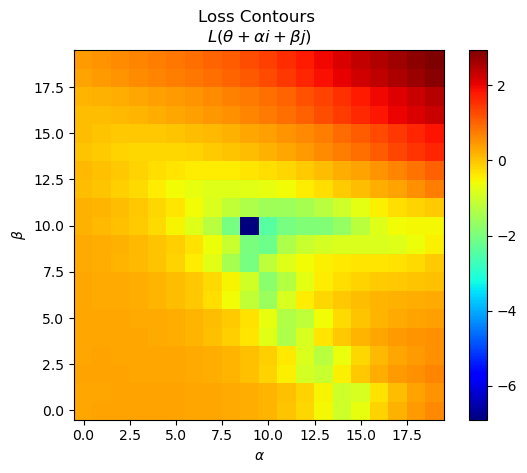

In [20]:
save_fig_name = os.path.join('loss_contours.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log10(loss_landscape_off_gpu), origin='lower', cmap='jet')
ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.axis('square')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

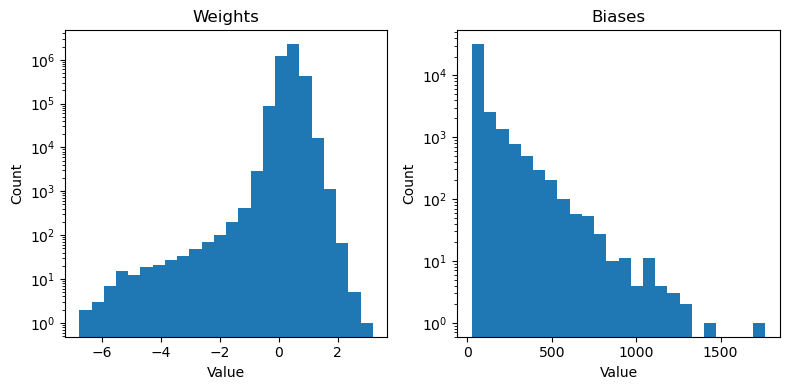

avg wt val:  0.23026651
std wt val:  8.65907


In [21]:
plot_model_wt_dist(model.to('cpu'))

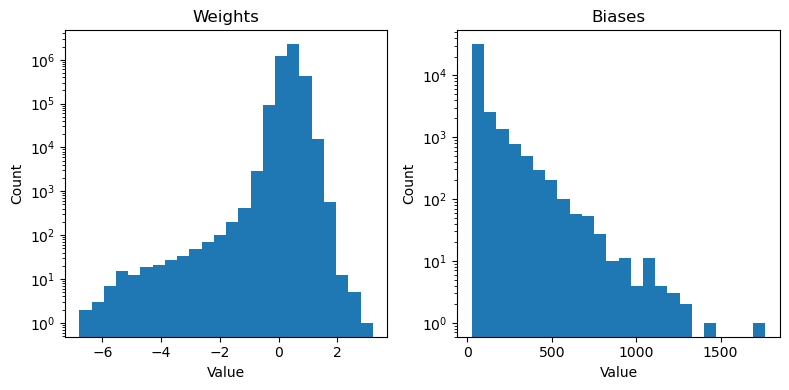

avg wt val:  0.23008904
std wt val:  8.659066


In [29]:
plot_model_wt_dist(mu_model.to('cpu'))

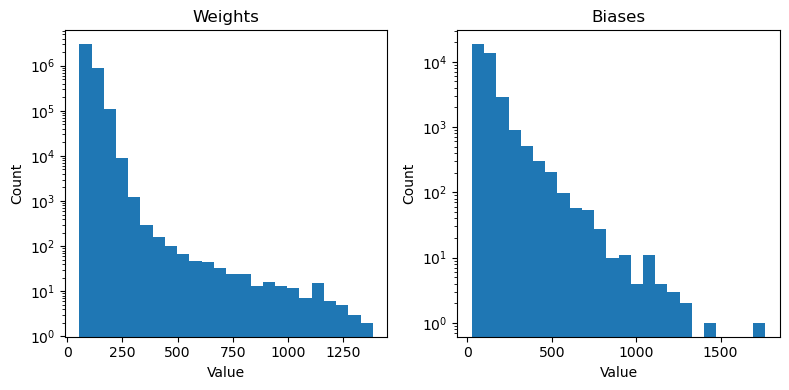

avg wt val:  39.362137
std wt val:  32.701138


In [30]:
# This cell will fail if there is an issue calculating the standard deviation
## Typically occurs due to NaN values in the standard deviation
plot_model_wt_dist(stddev_model.to('cpu'))

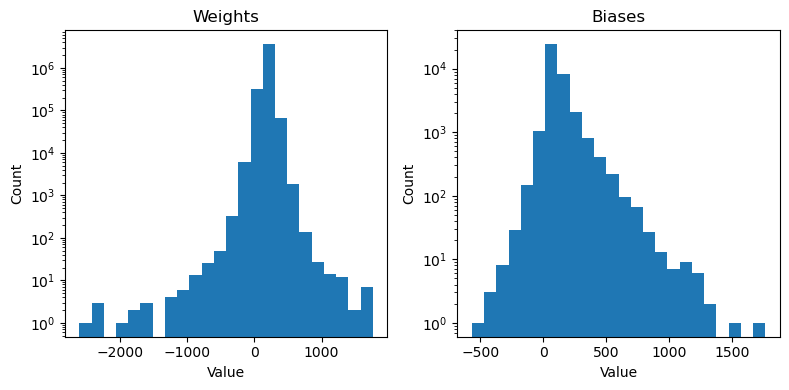

avg wt val:  0.22864215
std wt val:  51.1582


In [24]:
# This is how to generate and view the distribution of a single model generated from the distribution
sampled_model = get_sample_from_normal_dist_of_models(mu_model, stddev_model, model)
plot_model_wt_dist(sampled_model)

In [25]:
def get_prediction_var(data_loader, mu_model, stddev_model, model):
    sampled_model = get_sample_from_normal_dist_of_models(mu_model, stddev_model, model)
    # plot_model_wt_dist(sampled_model)
    sampled_model.to(device)
    model_new_train_predictions = []
    original_train_targets = []
    for s in tqdm(data_loader):
        original_train_targets.append(s[2].detach().numpy()[0])
        y_pred = np.expand_dims(sampled_model([s[0].to(device), s[1].to(device)]).cpu().detach().numpy(), axis=0)[0]
        model_new_train_predictions.append(y_pred)

    return model_new_train_predictions    

In [26]:
new_pred = get_prediction_var(train_dataloader, mu_model, stddev_model, model)

100%|██████████| 927/927 [00:10<00:00, 89.55it/s]


In [27]:
new_pred

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [28]:
pred_set = []
for _ in range(3):
    new_pred = get_prediction_var(train_dataloader, mu_model, stddev_model, model)
    pred_set.append(new_pred)


 55%|█████▌    | 513/927 [00:05<00:04, 88.04it/s]


KeyboardInterrupt: 

In [ ]:
test_pred_set = []
for _ in range(3):
    new_pred = get_prediction_var(test_dataloader, mu_model, stddev_model, model)
    test_pred_set.append(new_pred)

In [ ]:
np.array(pred_set).shape

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.var(np.array(pred_set), axis=0), bins=25, alpha=0.5, density=True)
ax.hist(np.var(np.array(test_pred_set), axis=0), bins=25, alpha=0.5, density=True)
plt.show()
